**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution.**

# Exercise 3

## Task 2: Hyperparameter Tuning (5 Points)

In this task, you will enhance your model’s performance through targeted modifications to the architecture. The main objectives include optimizing performance on the training dataset. The goal is to implement various changes and observe how they affect the overall performance of the model in terms of training and validation results, the smoothness and stability of the training curves, the number of trainable parameters, and the training time.

### Summary of Tasks for This Stage


**Task 2.1: Increase Convolution Channels** (1 point)

    Goal: Modify the model to increase the number of convolution channels to 128 across three layers.

**Task 2.2: Add One Convolution Layer** (1 point)

    Goal: Add an additional convolution layer to the model, creating four layers with 32 intermediate channels.

**Task 2.3: Adjust Kernel Sizes (Smaller)** (1 point)

    Goal: Modify the kernel sizes to be smaller than those used in the base model.

**Task 2.4: Adjust Kernel Sizes (Larger)** (1 point)

    Goal: Modify the kernel sizes to be larger than those used in the base model.

**Task 2.5: Change Non-linearities (ReLU)** (1 point)

    Goal: Replace the current activation functions with ReLU.

### Deliverables from this task:

* ex3_02_hyperparameter_tuning.ipynb
* 'relu_model.pth'
  

In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model. 

In [2]:
# Do not delete this cell

In [3]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import random

# Set random seeds for all libraries
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1) 

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Add the data path

In [5]:
path = "dataset_ex3" # you can change the path if you want to store the dataset somewhere else.

In [6]:
# Do not delete this cell

In [7]:
def prepare_file_list(path, validation_split):
    
    audio_class_names = ['music', 'speech']
    data_directories = {'music': path + '/music_wav', 
                        'speech': path + '/speech_wav'}
    
    audio_files = {class_name: [] for class_name in audio_class_names}
    for class_name in audio_class_names:
        folder = data_directories[class_name]
        filelist = os.listdir(folder)
        for filename in filelist:
            if filename.endswith('.wav'):
                audio_files[class_name].append(os.path.join(folder, filename))
       
    np.random.seed(1)
    dataset_split = {'train': [], 'val': []}
    for class_id, class_name in enumerate(audio_class_names):
        n_data = len(audio_files[class_name])
        random_indices = np.random.permutation(n_data)
        n_validation = int(validation_split * n_data)
        val_indices = random_indices[:n_validation]
        train_indices = random_indices[n_validation:]
        dataset_split['train'] += [(audio_files[class_name][k], class_id) for k in train_indices] 
        dataset_split['val'] += [(audio_files[class_name][k], class_id) for k in val_indices] 
    return dataset_split

In [8]:
class MSDataset(torch.utils.data.Dataset):
    
    def __init__(self, filelist, sample_sec=5., is_train=True):
        self.filelist = filelist
        self.time_duration = sample_sec
        self.is_train = is_train
        
        _, sf = librosa.load(filelist[0][0], sr = None)
        self.sf = sf
        self.n_features = int(self.time_duration * sf)
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, i):
        audio_file, class_id = self.filelist[i]
        x, sf = librosa.load(audio_file, sr = None)
        k = 0
            
        x = torch.from_numpy(x[k:k+self.n_features]).reshape(1,-1)
        
        return x, class_id

### Training and validation loops: 

Fill in the blanks as instructed in the code.

**Hint:** Replace the next cell with the training and validation loops from your solution to Task 1 in the ex3_01_base_model.ipynb file.

In [1]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    np.random.seed(1)
    if hist is not None:
        pass
    else:
        hist = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    best_accuracy = 0
    t_initial = time.time()
    
    for epoch in range(1, n_epochs + 1):
        start = time.time()
        train_loss, train_accuracy = 0., 0.
        num_samples = 0
        
        for input_batch, target_batch in dl_train: 
            # your code here for minibatch training
            # 1. call batch data and labels and set them to the correct device
            # 2. make the prediction on the data
            # 3. calculate loss
            # 4. set optimizer to zero grad
            # 5. do backward pass
            # 6. move the optimizer one step forward
            # YOUR CODE HERE
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)
            loss_train = loss_fn(predictions, target_batch)

            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            train_accuracy += (torch.argmax(predictions.detach(), dim=1) == target_batch).sum().item() # number of correct predictions
            train_loss += loss_train.item() * input_batch.shape[0]
            num_samples += input_batch.shape[0]
        
        train_loss /= num_samples
        train_accuracy /= num_samples       
        val_loss, val_accuracy = validation_loop(model, loss_fn, dl_val)
        
        end = time.time()
        epoch_time = round(end - start, 2)
        if epoch <= 5 or epoch % 10 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, train_loss {train_loss:.2f}, train_accuracy: {train_accuracy:.4f}, '
                   f'val_loss {val_loss:.2f}, val_accuracy: {val_accuracy:.4f}, time = {epoch_time}')

        # record for history return
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss) 
        hist['train_accuracy'].append(train_accuracy)
        hist['val_accuracy'].append(val_accuracy)
        
    t_final = time.time()
    t_total = round(t_final - t_initial, 2)
    minutes = int(t_total // 60)
    seconds = int(t_total % 60)
    print(f'Finished training_loop() within {minutes} minutes and {seconds} seconds')
    return hist

def validation_loop(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, total_accuracy, num_samples = 0., 0., 0.
        
        for input_batch, target_batch in dataloader:
            # your code here for minibatch validation
            # 1. set input_batch, target_batch to correct device
            # 2. make the prediction on input_batch
            # 3. calculate loss and add it to previous loss
            # 4. obtain predicted class labels from predictions (hint: use torch.argmax)
            # YOUR CODE HERE
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)
            loss_train = loss_fn(predictions, target_batch)
            total_loss += loss_train.item() * input_batch.shape[0]

            predicted_classes = torch.argmax(predictions.detach(), dim=1)
            ###
            
            total_accuracy += (predicted_classes == target_batch).sum().item()
            num_samples += len(target_batch)
    
    average_loss = total_loss / num_samples
    average_accuracy = total_accuracy / num_samples
    
    return average_loss, average_accuracy

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].set_title('Loss')
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Validation')
    axes[0].legend()

    max_val_accuracy = max(history['val_accuracy'])
    axes[1].set_title(f'Accuracy (Best: {max_val_accuracy:.2f})')
    axes[1].plot(history['train_accuracy'], label='Train')
    axes[1].plot(history['val_accuracy'], label='Validation')
    axes[1].legend()

### Task 2.1. Increase Convolution Channels

Use the base model from Task 1, increasing the convolutional channels from 32 to 128. Fill in the blanks in the cell below as instructed in the code.

In [10]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 128
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Input channels: 128 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 4. Create a global average pooling layer to reduce the spatial dimensions
        # 5. Create a flattening layer to flatten the output for the final layer
        # 6. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.hidden1 = BasicBlock(in_channels=1,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.hidden2 = BasicBlock(in_channels=128,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.hidden3 = BasicBlock(in_channels=128,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Apply global average pooling to reduce dimensions
        # 5. Flatten the pooled output
        # 6. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.hidden1(x)
        conv2 = self.hidden2(conv1)
        conv3 = self.hidden3(conv2)

        pooled = self.pool(conv3)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)

        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params    

Run the cell below to verify the correctness of your solution for the model architecture.

In [11]:
# Visible tests here
all_tests_successful = True
model = MyModel("Tanh")
dummy_input = torch.randn(1, 1, 22000)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 3:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [128, 128, 2]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        
# Check the output shape
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 184706
if num_params != expected_num_parameters:
    all_tests_successful = False
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    
# Check the output range for LogSoftmax (should be <= 0)
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 184706 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Train and Validate

Now, run the cell below to apply training and validation. 

Compare the results with those from the base model in Task 1. Observe how increasing the number of channels in the convolutional layers affects the model's performance on the training and validation splits. Additionally, note how this change impacts the number of training parameters and the training time.

The model has 184706 trainable parameters.
Epoch 1, train_loss 0.88, train_accuracy: 0.4111, val_loss 0.74, val_accuracy: 0.5000, time = 4.39
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 4.11
Epoch 3, train_loss 0.68, train_accuracy: 0.5222, val_loss 0.69, val_accuracy: 0.5000, time = 4.04
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 4.45
Epoch 5, train_loss 0.71, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 4.27
Epoch 10, train_loss 0.71, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.97
Epoch 20, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 4.63
Epoch 30, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.82
Epoch 40, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.92
Epoch 50, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.

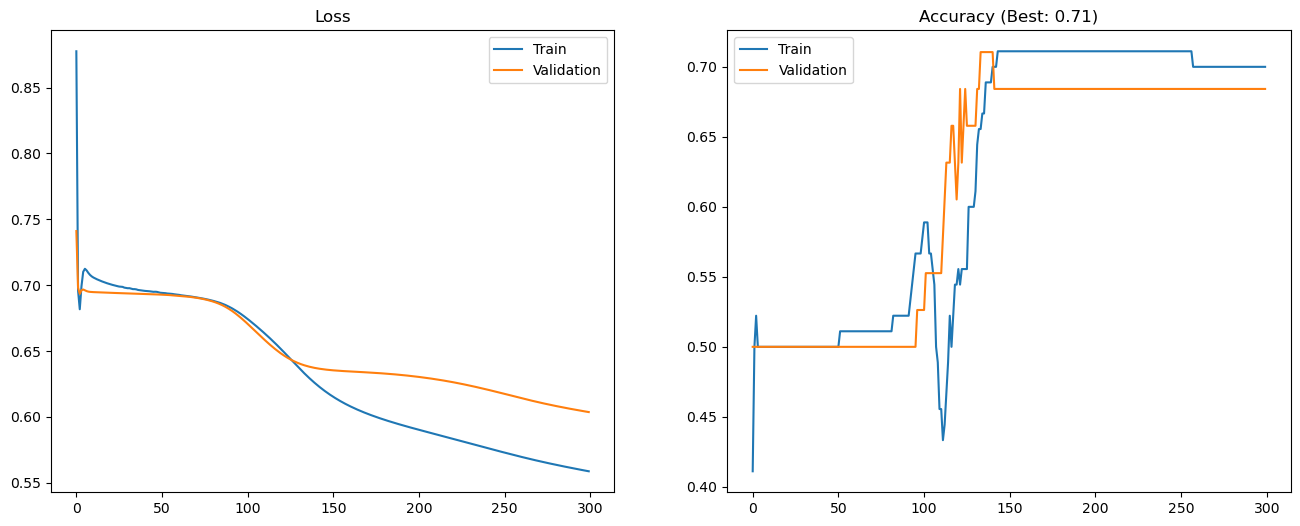

In [12]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("Tanh").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'model.pth')
    plot_history(history)   

In [13]:
# Visible tests for checking the performance of the trained model
all_tests_successful = True
if not skip_training:
    try:
    
        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(history['train_accuracy'])
        if not (0.5 <= max_tacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.5, 1].")
            
        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(history['val_accuracy'])
        if not (0.5 <= max_vacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")
    
        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")
    
    except AssertionError as e:
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")

All visible tests for training and validation accuracy passed successfully!


### Task 2.2: Add One Convolution Layer

Next, use the base model from Task 1 (32 channels), adding one extra the convolutional layers to have 4 convolutional layers with 32 intermediate filters (channels). Fill in the blanks in the cell below as instructed in the code.

In [14]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 4. Create the forth hidden layer using BasicBlock
        #    - Input channels: 32 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 5. Create a global average pooling layer to reduce the spatial dimensions
        # 6. Create a flattening layer to flatten the output for the final layer
        # 7. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.hidden1 = BasicBlock(in_channels=1,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden2 = BasicBlock(in_channels=32,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden3 = BasicBlock(in_channels=32,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden4 = BasicBlock(in_channels=32,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Pass the output to the forth hidden layer
        # 5. Apply global average pooling to reduce dimensions
        # 6. Flatten the pooled output
        # 7. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.hidden1(x)
        conv2 = self.hidden2(conv1)
        conv3 = self.hidden3(conv2)
        conv4 = self.hidden4(conv3)

        pooled = self.pool(conv4)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)
        
        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params    

Run the cell below to verify the correctness of your solution for the model architecture.

In [15]:
# Visible tests here
all_tests_successful = True
model = MyModel("Tanh")
dummy_input = torch.randn(1, 1, 22000)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 4:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [32, 32, 32, 2]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        
# Check the output shape
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 23682
if num_params != expected_num_parameters:
    all_tests_successful = False
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    
# Check the output range for LogSoftmax (should be <= 0)
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 23682 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Train and Validate

Now, run the cell below to apply training and validation. 

Compare the results with those from the base model in Task 1 and the model from Task 2.1. Observe how increasing the number of convolutional layers affects the model's performance on the training and validation splits. Additionally, note how this change impacts the number of training parameters and the training time.

The model has 23682 trainable parameters.
Epoch 1, train_loss 0.72, train_accuracy: 0.1444, val_loss 0.69, val_accuracy: 0.5000, time = 1.56
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.25
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.04
Epoch 4, train_loss 0.69, train_accuracy: 0.3889, val_loss 0.69, val_accuracy: 0.5000, time = 1.07
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.0
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.3
Epoch 20, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.94
Epoch 30, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.94
Epoch 40, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.9
Epoch 50, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, 

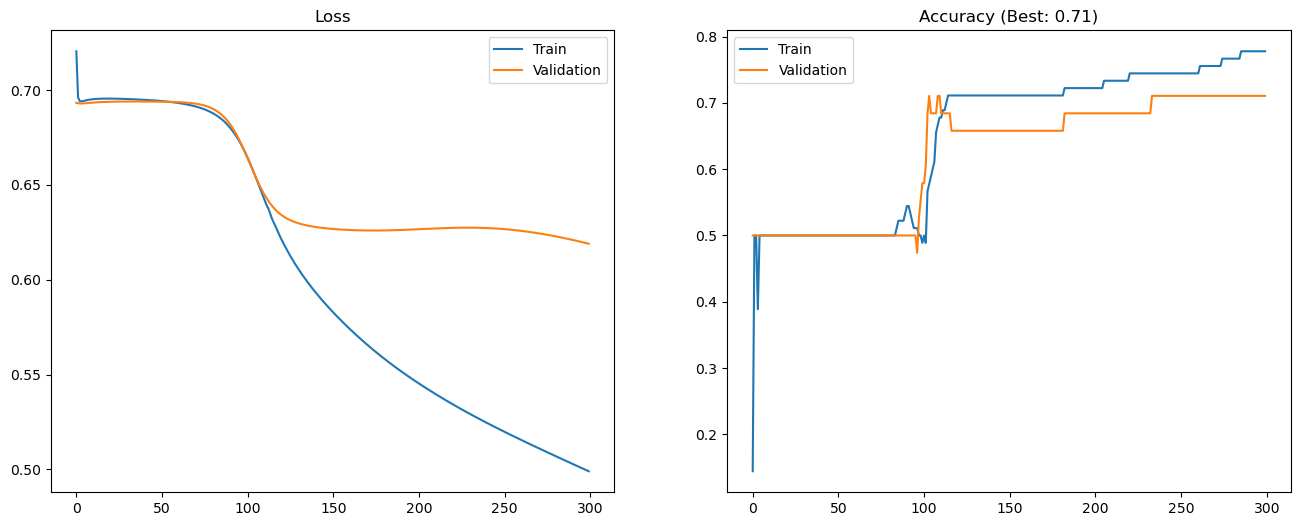

In [16]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("Tanh").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'model.pth')
    plot_history(history)

### Task 2.3: Adjust Kernel Sizes (Smaller)

In this task, you will modify the base model by using smaller kernel sizes for the convolutional layers. Set the kernel size to 7 and the stride to 3. Fill in the blanks in the code cell below as directed to apply these changes.

In [17]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        # Define the convolutional layer with a kernel size of 7 and stride of 3
        # YOUR CODE HERE
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=7,
                                    stride=3)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x
        
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Input channels: 32 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 4. Create a global average pooling layer to reduce the spatial dimensions
        # 5. Create a flattening layer to flatten the output for the final layer
        # 6. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.hidden1 = BasicBlock(in_channels=1,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden2 = BasicBlock(in_channels=32,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden3 = BasicBlock(in_channels=32,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Apply global average pooling to reduce dimensions
        # 5. Flatten the pooled output
        # 6. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.hidden1(x)
        conv2 = self.hidden2(conv1)
        conv3 = self.hidden3(conv2)

        pooled = self.pool(conv3)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)

        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

Run the cell below to verify the correctness of your solution for the model architecture.

In [18]:
# Visible tests here
all_tests_successful = True
model = MyModel("Tanh")
dummy_input = torch.randn(1, 1, 22000)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 3:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [32, 32, 2]  # Expected output channels for the three layers
expected_kernels = [7, 7, 7]

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
    # Check the kernel size
    if layer.kernel_size[0] != expected_kernels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have the expected kernel size of {expected_kernels[i]}. It has {layer.kernel_size}.")    
# Check the output shape
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 7906
if num_params != expected_num_parameters:
    all_tests_successful = False
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    
# Check the output range for LogSoftmax (should be <= 0)
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 7906 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Train and Validate

Now, run the cell below to train and validate the model.

Compare the results with those of the base model from Task 1. Observe how using smaller kernel sizes influences the model's performance on the training and validation datasets. Additionally, take note of any changes in the number of training parameters and the training duration.

The model has 7906 trainable parameters.
Epoch 1, train_loss 0.71, train_accuracy: 0.2333, val_loss 0.69, val_accuracy: 0.5000, time = 1.85
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.76
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.51
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.23
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.6
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.13
Epoch 20, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.51
Epoch 30, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.41
Epoch 40, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.15
Epoch 50, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69,

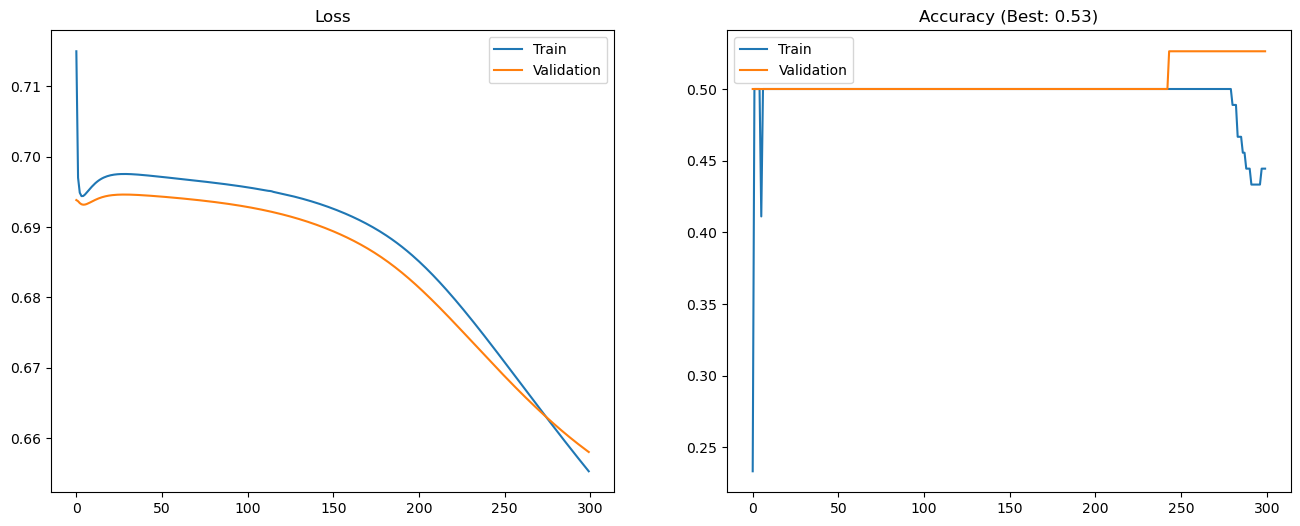

In [19]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("Tanh").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'model.pth')
    plot_history(history)

### Task 2.4: Adjust Kernel Sizes (Larger)

In this step, return to the base model and modify the kernel sizes of the convolutional layers to be larger. Use kernels of size 22 and a stride of 11. Complete the cell below by filling in the blanks as specified in the code.

In [20]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        # Define the convolutional layer with a kernel size of 22 and stride of 11
        # YOUR CODE HERE
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=22,
                                    stride=11)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x
        
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Input channels: 32 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 4. Create a global average pooling layer to reduce the spatial dimensions
        # 5. Create a flattening layer to flatten the output for the final layer
        # 6. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.hidden1 = BasicBlock(in_channels=1,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden2 = BasicBlock(in_channels=32,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden3 = BasicBlock(in_channels=32,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Apply global average pooling to reduce dimensions
        # 5. Flatten the pooled output
        # 6. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.hidden1(x)
        conv2 = self.hidden2(conv1)
        conv3 = self.hidden3(conv2)

        pooled = self.pool(conv3)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)

        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

Run the cell below to verify the correctness of your solution for the model architecture.

In [21]:
# Visible tests here
all_tests_successful = True
model = MyModel("Tanh")
dummy_input = torch.randn(1, 1, 22000)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)
expected_kernels = [22, 22, 22]


# Test the number of Conv1d layers
if conv1d_count != 3:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [32, 32, 2]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
    # Check the kernel size
    if layer.kernel_size[0] != expected_kernels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have the expected kernel size of {expected_kernels[i]}. It has {layer.kernel_size}.")    

# Check the output shape
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 24706
if num_params != expected_num_parameters:
    all_tests_successful = False
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    
# Check the output range for LogSoftmax (should be <= 0)
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 24706 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Train and Validate

Run the cell below to apply training and validation.

Compare these results with those from the base model in Task 1 and the smaller kernel sizes in Task 2.3. Observe how using larger kernel sizes influences the model's performance on the training and validation sets. Also, note any changes in the number of training parameters and training time.


The model has 24706 trainable parameters.
Epoch 1, train_loss 0.74, train_accuracy: 0.3222, val_loss 0.70, val_accuracy: 0.5000, time = 0.9
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.39
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.46
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.62
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5263, time = 0.83
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.51
Epoch 20, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.96
Epoch 30, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.38
Epoch 40, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.46
Epoch 50, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69

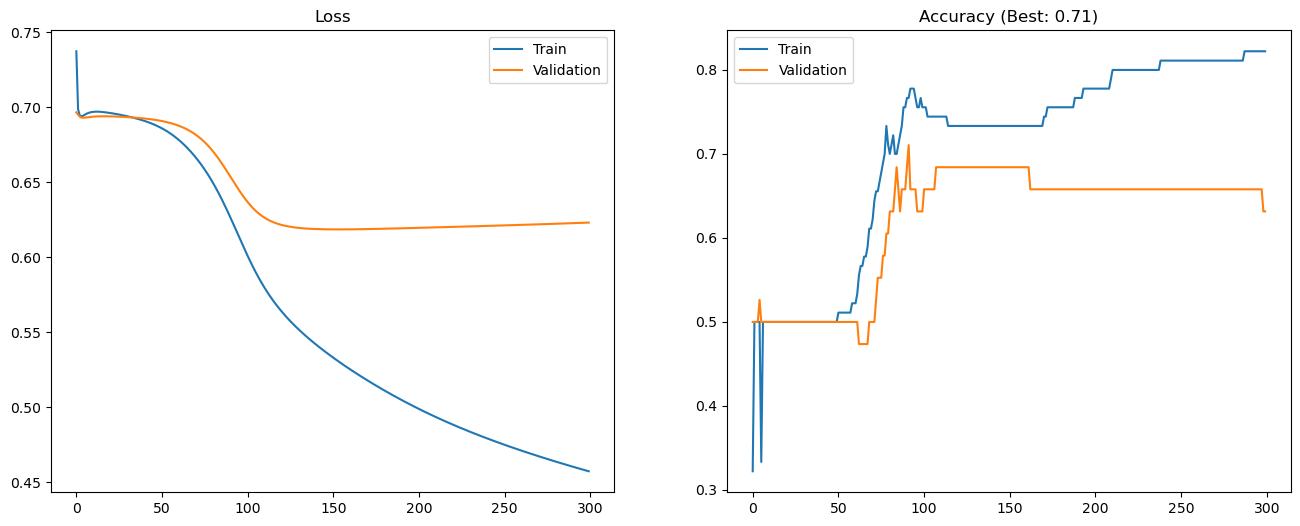

In [22]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("Tanh").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'model.pth')
    plot_history(history)

### Task 2.5: Change Non-linearities

For this task, return to the base model and explore the impact of different non-linear activation functions on the model's performance.

Re-create the base model by filling in the blanks in the cell below as instructed. Try using "ReLU" as an alternative activation function to see how that affect training and validation results.

Save the model as **'relu_model.pth'** and submit it to Moodle along with your other files.


In [23]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x
        
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Input channels: 32 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 4. Create a global average pooling layer to reduce the spatial dimensions
        # 5. Create a flattening layer to flatten the output for the final layer
        # 6. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.hidden1 = BasicBlock(in_channels=1,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden2 = BasicBlock(in_channels=32,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden3 = BasicBlock(in_channels=32,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Apply global average pooling to reduce dimensions
        # 5. Flatten the pooled output
        # 6. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.hidden1(x)
        conv2 = self.hidden2(conv1)
        conv3 = self.hidden3(conv2)

        pooled = self.pool(conv3)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)

        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

### Train and Validate

In this task, set the non-linearity function in the convolutional layers to **"ReLU"**. Fill in the blanks in the cell below following the instructions in the code. 

After training, compare the results with the base model that used **"Tanh"** as the activation function. Observe any differences in training and validation performance, noting any changes in training dynamics, convergence rate, or accuracy.

Remember to save the model as **'relu_model.pth'** and submit it to Moodle along with your other files.

The model has 12386 trainable parameters.
Epoch 1, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.89
Epoch 2, train_loss 0.69, train_accuracy: 0.4667, val_loss 0.69, val_accuracy: 0.5263, time = 0.7
Epoch 3, train_loss 0.69, train_accuracy: 0.4556, val_loss 0.69, val_accuracy: 0.5526, time = 0.77
Epoch 4, train_loss 0.69, train_accuracy: 0.4667, val_loss 0.69, val_accuracy: 0.5000, time = 0.82
Epoch 5, train_loss 0.69, train_accuracy: 0.4667, val_loss 0.69, val_accuracy: 0.5000, time = 0.81
Epoch 10, train_loss 0.69, train_accuracy: 0.4889, val_loss 0.69, val_accuracy: 0.5263, time = 0.73
Epoch 20, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.74
Epoch 30, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.68
Epoch 40, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.68
Epoch 50, train_loss 0.68, train_accuracy: 0.5000, val_loss 0.69

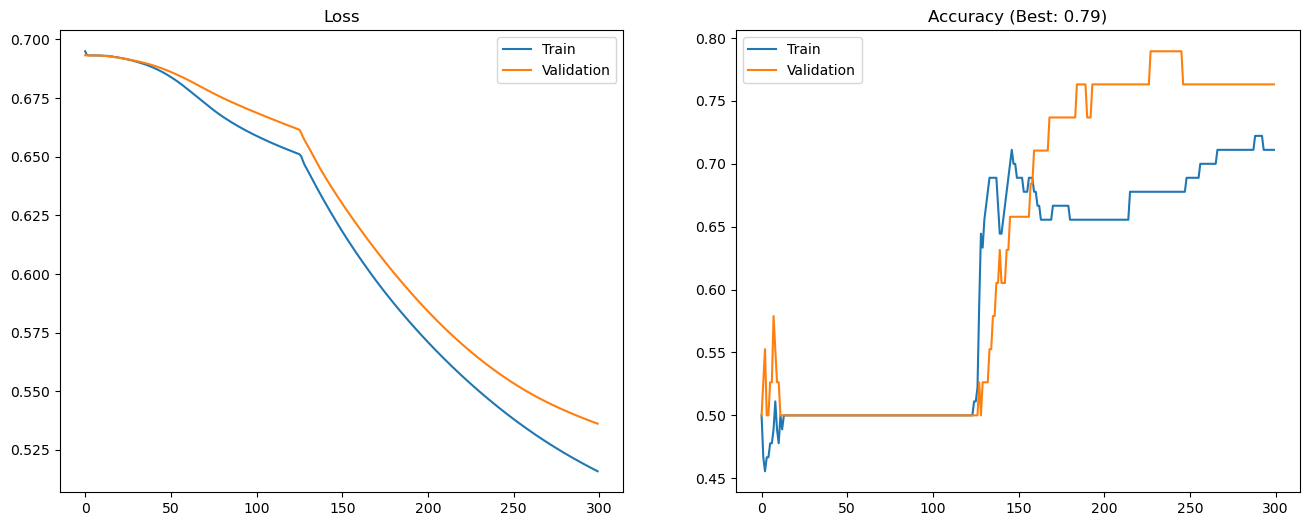

In [24]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
# your code here for calling model with "ReLU" non-linearity
# YOUR CODE HERE
model = MyModel("ReLU").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'relu_model.pth')
    plot_history(history) 

In [25]:
# Visible tests for checking the performance of the trained model
all_tests_successful = True
if not skip_training:
    try:
        # Test 0: Ensure non-linearity is ReLU
        basic_blocks = [layer for layer in model.modules() if isinstance(layer, BasicBlock)]
        for i, block in enumerate(basic_blocks):
            if not isinstance(block.activation_fn, nn.ReLU):
                all_tests_successful = False
                raise AssertionError(f"BasicBlock {i + 1} does not use ReLU as the activation function.")
    
        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(history['train_accuracy'])
        if not (0.5 <= max_tacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.5, 1].")
            
        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(history['val_accuracy'])
        if not (0.5 <= max_vacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")
    
        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")
    
    except AssertionError as e:
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")

All visible tests for training and validation accuracy passed successfully!


In [32]:
# Do not delete this cell